In [49]:
import glob
import math
import os
import random
import shutil
from pathlib import Path
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [17]:
# for training and testing

class TrainImgLabels(Dataset):
    def __init__(self, img_file, batch_size=16, augment=False, class_weights=False):
        with open(img_file, "r") as fin:
            self.img_paths = list(fin.read().splitlines())
        n = len(self.img_paths)
        batch_idx = np.floor(np.arange(n) / batch_size).astype(np.int)
        num_batch = batch_idx[-1] + 1
        
        self.n = n
        self.batch = batch_idx
        self.augment = augment
        self.class_weights = class_weights
        
        self.label_files = [x.replace('image', 'bbox').               #################what is this for#######
                        replace('.jpeg', '.txt').
                        replace('.jpg', '.txt').
                        replace('.bmp', '.txt').
                        replace('.png', '.txt') for x in self.img_paths] 
        
        # preload labels
        self.imgs = [None] * n
        self.labels = [np.zeros((0, 5))] * n
        iter = tqdm(self.label_files, desc='Reading labels')
        for i, file in enumerate(iter):
            try:
                with open(file, 'r') as f:
                    l = np.array([x.split() for x in f.read().splitlines()], dtype=np.float32)
                    if l.shape[0]:
                        assert l.shape[1] == 5, '> 5 label columns: %s' % file
                        assert (l >= 0).all(), 'negative labels: %s' % file
                        assert (l[:, 1:] <= 1).all(), 'non-normalized or out of bounds coordinate labels: %s' % file
                        self.labels[i] = l
            except FileNotFoundError:
                pass  # print('Warning: missing labels for %s' % self.img_files[i])  # missing label file
        assert len(np.concatenate(self.labels, 0)) > 0, 'No labels found. Incorrect label paths provided.'
        
        
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        if self.class_weights:  #####################################CLASS WEIGHT###################
            index = self.indices[index] 
        
        # images
        img_path = self.img_paths[index]
        img = cv2.imread(img_path)
        img = img[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) # BGR to RGB
        ##########################WHY NOT MIN MAX NORMALIZATION###########################
        img = img / 255.0 
        #############################################################################
        assert img is not None, "Image not found" + img_path
        
        # load labels
        label_path = self.label_files[index]
        labels = []
#         if os.path.isfile(label_path):
#             x = self.labels[index]
        nL = len(labels)
            
        
        return torch.from_numpy(img), label
        

In [24]:
tmp = TrainImgLabels('./data/img.txt')



Reading labels:   0%|          | 0/5 [00:00<?, ?it/s]

Reading labels: 100%|██████████| 5/5 [00:00<00:00, 4385.51it/s]

In [29]:
tmp[0][0].shape

torch.Size([3, 360, 640])

In [2]:
class Image(Dataset):
    def __init__(self, ID):
        #self.files = sorted(glob.glob("%s/*.*" % folder_path))
#         with open(img_txt, "r") as fin:
#             self.img_paths = list(fin.read().splitlines())
        #self.img_size = img_size
        self.img_path = './image/' + ID + '.jpg'
    
    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        img_path = self.img_path
        # Extract image as PyTorch tensor
        img = cv2.imread(img_path)
        img = img.transpose(2, 0, 1).astype(np.float32) # BGR to RGB
        ############################### /255 for normalization for now################
        #img /= 255
        #############################################################################
#         # Pad to square resolution
#         img, _ = pad_to_square(img, 0)
#         # Resize
#         img = resize(img, self.img_size)

        return img

class Label(Dataset):
    def __init__(self, ID):
#         with open(label_txt, "r") as fin:
#             self.label_paths = list(fin.read().splitlines())
        self.label_path = './bbox/' + ID + '.txt'
    
    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        label_path = self.label_path
        box = torch.from_numpy(np.loadtxt(label_path).reshape(-1, 5))
        target = torch.zeros((len(box), 5))
        target[:, :] = box
        return target
        

In [38]:
def get_img(ID):
    img_path = './image/' + ID + '.jpg'
    img = cv2.imread(img_path)
    img = img[:, :, [2,1,0]].astype(np.float32) # BGR to RGB
    ############################### /255 for normalization for now################
    img /= 255
    img = torch.from_numpy(img)
    #############################################################################
    #plt.imshow(img)
    return img

def get_label(ID):
    label_path = './bbox/' + ID + '.txt'
    box = torch.from_numpy(np.loadtxt(label_path).reshape(-1, 5))
    
    return box

In [39]:
class TrainData(Dataset):
    def __init__(self, ID_txt):
        with open(ID_txt, "r") as f:
            self.ID = list(f.read().splitlines())
    
    def __len__(self):
        return len(self.ID)
    
    def __getitem__(self, index):
        ID = self.ID[index]
        img = get_img(ID)
        label = get_label(ID)
        return img, label

In [62]:
id_txt = './data/id.txt'

In [67]:
def collate_fn(batch):
    img = [item[0] for item in batch]
    label = [item[1] for item in batch]
    stacked_img = torch.stack(img)
    cat_label = torch.cat(label)
    idx = []
    for i, one_img_label in enumerate(label):
        l = len(one_img_label)
        idx.extend([i] * l)
    idx = torch.LongTensor(idx).reshape(-1, 1)    

    return stacked_img, cat_label, idx



In [68]:
dl = DataLoader(TrainData(id_txt), batch_size=2, shuffle=True, collate_fn=collate_fn)

In [69]:
len(dl)

2

In [72]:
for batch in dl:
    print(batch[0].shape, batch[1].shape, batch[2].shape)


torch.Size([2, 360, 640, 3]) torch.Size([4, 5]) torch.Size([4, 1])
torch.Size([2, 360, 640, 3]) torch.Size([5, 5]) torch.Size([5, 1])


In [ ]:
for i in range(210):
    

In [44]:
img_path = './image/' + ID + '.jpg'

In [151]:
img = cv2.imread(img_path)

In [45]:
from itertools import permutations

(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)


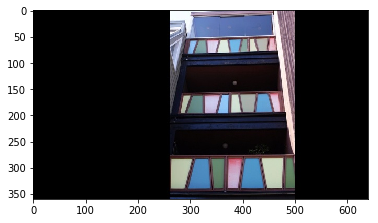

In [46]:
for perm in permutations(range(3)):
    img = cv2.imread(img_path)    
    img = img[:, :, perm]
    img = img / 255
    plt.imshow(img)
    print (img.shape)
    

In [156]:
perm

(2, 1, 0)

In [ ]:
# img = img.transpose(2, 0, 1).astype(np.float32) # BGR to RGB

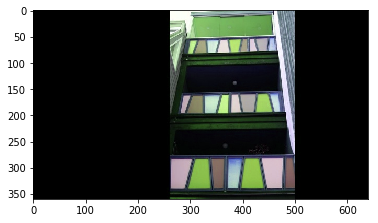

In [153]:
############################### /255 for normalization for now################
img = img / 255
#############################################################################
# img2 = img.reshape(360, 640, 3)

plt.imshow(img)
#return img

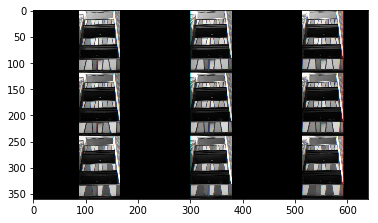

In [119]:
get_img('n02777734_411')

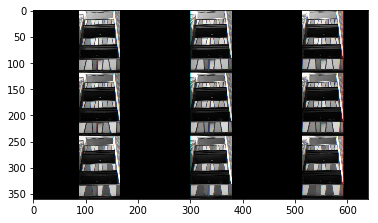

In [114]:
img2 = img.reshape(360, 640, 3)

plt.imshow(img2)

In [113]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, *, data=None, **kwargs)
    Display an image, i.e. data on a 2D regular raster.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The data is visualized
          using a colormap.
        - (M, N, 3): an image with RGB values (float or uint8).
        - (M, N, 4): an image with RGBA values (float or uint8), i.e.
          including transparency.
    
        The first two dimensions (M, N) define the rows and columns of
        the image.
    
        The RGB(A) values should be in the range [0 .. 1] for floats or
        [0 .. 255] for integers.  Out-of-range values will be clipped to
        these bounds.
    
   

TypeError: Image data cannot be converted to float

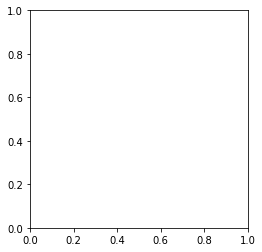

In [95]:
img_path = './image/n02777734_411.jpg'
plt.imshow(img_path)

In [76]:
TrainData('./data/id.txt')[1][1][4]

tensor([[1.0000, 0.4087, 0.1920, 0.1766, 0.0840],
        [1.0000, 0.4147, 0.3430, 0.1766, 0.1020]])

In [ ]:
def collate_fun(self, batch):
    

In [ ]:
# for inference

In [ ]:
# for web cam